# Social Media Data Analysis with Python-part1
This notebook will guide you through performing basic machine learning tasks on social media data using Python.
We'll use libraries like `pandas`, `scikit-learn`, and `nltk` to analyze text data, perform sentiment analysis, and make predictions.

---

## Steps We'll Cover
[Check it here!](https://www.kaggle.com/code/muhammadimran112233/eda-twitter-sentiment-analysis-using-nn/notebook)
1. Data Preparation 
2. Implementing Tensorflow based model for training 🧪
3. Model Evaluation
4. Improvements? 



 #### APIs for Social Media Data Collection
- [Twitter API v2 Documentation](https://developer.twitter.com/en/docs/twitter-api)
- [Reddit API (PRAW Documentation)](https://praw.readthedocs.io/)
- [Facebook Graph API Documentation](https://developers.facebook.com/docs/graph-api)
- [YouTube Data API](https://developers.google.com/youtube/v3)
- [Instagram Graph API](https://developers.facebook.com/docs/instagram-api)

#### Datasets for Social Media Analysis
- [Sentiment140 Twitter Dataset on Kaggle](https://www.kaggle.com/datasets/kazanova/sentiment140)
- [COVID-19 Tweets Dataset on Kaggle](https://www.kaggle.com/datasets/datatattle/covid-19-nlp-text-classification)
- [Twitter US Airline Sentiment Dataset on Kaggle](https://www.kaggle.com/datasets/crowdflower/twitter-airline-sentiment)
- [Reddit Comments Dataset on Google BigQuery](https://console.cloud.google.com/marketplace/details/google/reddit-comments)
- [Hugging Face Social Media Dataset](https://huggingface.co/datasets)

In [1]:
import numpy as np 
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import classification_report, confusion_matrix
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer 
from sklearn.model_selection import train_test_split
from mlxtend.plotting import plot_confusion_matrix
import matplotlib.cm as cm
from matplotlib import rcParams
from collections import Counter
from nltk.tokenize import RegexpTokenizer
import re
import string
from tensorflow.keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence

from IPython.display import Image, display
from sklearn.model_selection import KFold

%matplotlib inline



import warnings
warnings.filterwarnings("ignore")

2024-11-12 15:04:32.959258: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1731423872.986702 2207505 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1731423872.994919 2207505 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
# Load the dataset
file_path = 'sentiment140.csv'
df_complete = pd.read_csv(file_path, encoding = "ISO-8859-1", engine="python")
df_complete.columns = ["label", "time", "date", "query", "username", "text"]
df_complete['label'][df_complete['label']==4]=1

# View the first few rows
df_complete.head()


# Label dataset for training
# n=100000 selects 50 random rows
df = df_complete.sample(n=200000, random_state=42)

# Data Preparation

In [4]:
# Lower case
df['text']=df['text'].str.lower()

In [5]:
df.iloc[100].text

"@powersurf oh i've got a case. i designed it. someone idiot stole it and i can prove it. if they want to play hardball,i'm game. "

In [6]:
# Preprocess the text data
stop_words = set(stopwords.words('english'))

# Remove stop words from the text
df['text_cleaned'] = df['text'].apply(lambda x: ' '.join([word for word in x.lower().split() if word not in stop_words]).strip())

In [7]:
df.iloc[100].text_cleaned

"@powersurf oh i've got case. designed it. someone idiot stole prove it. want play hardball,i'm game."

In [8]:
# Removing mentions 
def removing_mentions(data):
    return re.sub('@[^\s]+', ' ', data)
df['text_cleaned']= df['text_cleaned'].apply(lambda x: removing_mentions(x).strip())

In [9]:
df.iloc[100].text_cleaned

"oh i've got case. designed it. someone idiot stole prove it. want play hardball,i'm game."

In [10]:
# Remove URLs
def cleaning_URLs(data):
    return re.sub('((www\.[^\s]+)|(https?://[^\s]+))',' ',data)

df['text_cleaned']= df['text_cleaned'].apply(lambda x: cleaning_URLs(x))

In [11]:
df.iloc[100].text_cleaned

"oh i've got case. designed it. someone idiot stole prove it. want play hardball,i'm game."

In [12]:
# Remove puntaction
english_punctuations = string.punctuation.replace('#', '')
punctuations_list = english_punctuations.replace('#', '')

def cleaning_punctuations(text):
    translator = str.maketrans('', '', punctuations_list)
    return text.translate(translator)

df['text_cleaned']= df['text_cleaned'].apply(lambda x: cleaning_punctuations(x))

In [13]:
df.iloc[100].text_cleaned

'oh ive got case designed it someone idiot stole prove it want play hardballim game'

In [14]:
# Cleaning and removing repeating characters
def cleaning_repeating_char(text):
    return re.sub(r'(.)\1+', r'\1', text)

df['text_cleaned']= df['text_cleaned'].apply(lambda x: cleaning_repeating_char(x))

In [15]:
df.iloc[100].text_cleaned

'oh ive got case designed it someone idiot stole prove it want play hardbalim game'

In [16]:
# Remove Numbers
def cleaning_numbers(data):
    return re.sub('[0-9]+', '', data)

df['text_cleaned']= df['text_cleaned'].apply(lambda x: cleaning_numbers(x))

In [17]:
df.iloc[100].text_cleaned

'oh ive got case designed it someone idiot stole prove it want play hardbalim game'

In [18]:
# Tokenization
tokenizer = RegexpTokenizer(r'\w+')
df['text_cleaned'] = df['text_cleaned'].apply(tokenizer.tokenize)

In [19]:
df.iloc[100].text_cleaned

['oh',
 'ive',
 'got',
 'case',
 'designed',
 'it',
 'someone',
 'idiot',
 'stole',
 'prove',
 'it',
 'want',
 'play',
 'hardbalim',
 'game']

In [20]:
# Lemmitizer: "better" → "good"
lm = nltk.WordNetLemmatizer()
def lemmatizer_on_text(data):
    text = [lm.lemmatize(word) for word in data]
    return text

df['text_cleaned'] = df['text_cleaned'].apply(lambda x: lemmatizer_on_text(x))

In [21]:
df.iloc[100].text_cleaned

['oh',
 'ive',
 'got',
 'case',
 'designed',
 'it',
 'someone',
 'idiot',
 'stole',
 'prove',
 'it',
 'want',
 'play',
 'hardbalim',
 'game']

In [22]:
df.dropna(inplace=True)
df['text_cleaned'] = df['text_cleaned'].astype(str)

In [23]:
X=df.text_cleaned
y=df.label

In [24]:
max_len = 200
tok = Tokenizer(num_words=5000)
tok.fit_on_texts(X)
sequences = tok.texts_to_sequences(X)

In [25]:
sequences[0]

[242, 104, 2152, 19, 88, 184, 211, 65, 60]

In [26]:
min([len(i) for i in X])

2

In [27]:
max([len(i) for i in X])

462

- **Pads shorter sequences** with zeros or a specified value.
- **Truncates longer sequences** to a specified maximum length.
- **Ensures consistent input length** for neural networks.
- **Needed** because neural networks require fixed-length inputs to process data in batches.

In [28]:
sequences_matrix = sequence.pad_sequences(sequences,maxlen=max_len)

In [29]:
sequences_matrix[0]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,   

In [30]:
X_train, X_test, Y_train, Y_test = train_test_split(sequences_matrix, y, test_size=0.3, random_state=2)

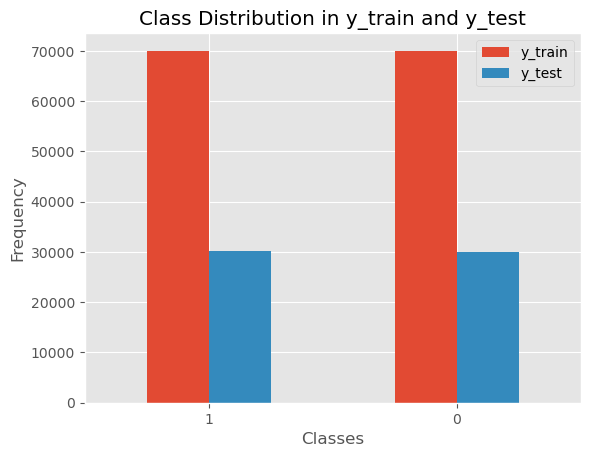

In [33]:
# Convert y_train and y_test to pandas Series for value_counts
y_train = pd.Series(Y_train)
y_test = pd.Series(Y_test)

# Combine y_train, y_test into a list of their respective groups
labels = ['y_train', 'y_test']
class_counts = [y_train.value_counts(), y_test.value_counts()]

# Create a DataFrame for better plotting
df_counts = pd.DataFrame({labels[0]: y_train.value_counts(), labels[1]: y_test.value_counts()}).fillna(0)

# Plot
df_counts.plot(kind='bar', stacked=False)
plt.title('Class Distribution in y_train and y_test')
plt.xlabel('Classes')
plt.ylabel('Frequency')
plt.xticks(rotation=0)
plt.show()

# Implementing Tensorflow based model for training 🧪


In [34]:
def tensorflow_based_model(): #Defined tensorflow_based_model function for training tenforflow based model
    #step1
    inputs = Input(name='inputs',shape=[200])
    #step2
    layer = Embedding(5000,50,input_length=200)(inputs) 
    #step3
    layer = LSTM(64)(layer) 
    #step4
    layer = Dense(256,name='FC1')(layer) 
    # step5
    layer = Activation('relu')(layer) 
    # step6
    layer = Dropout(0.5)(layer) 
    #step4 again but this time its giving only one output as because we need to classify the tweet as positive or negative
    layer = Dense(1,name='out_layer')(layer) 
    #step5 but this time activation function is sigmoid for only one output.
    layer = Activation('sigmoid')(layer) 
     #here we are getting the final output value in the model for classification
    model = Model(inputs=inputs,outputs=layer)
    return model #function returning the value when we call it

# here we are calling the function of created model
model = tensorflow_based_model() 
model.compile(loss='binary_crossentropy',optimizer=RMSprop(),metrics=['accuracy'])  

model.summary()

2024-11-12 15:05:41.771600: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ inputs (InputLayer)             │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 200, 50)        │       250,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 64)             │        29,440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ FC1 (Dense)                     │ (None, 256)            │        16,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ out_layer (Dense)               │ (None, 1)              │           257 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 296,337 (1.13 MB)

 Trainable params: 296,337 (1.13 MB)

 Non-trainable params: 0 (0.00 B)

1. The input to model is 100 words because these are the number features/words that we extracted above from text of tweets.
2. Embeddings provide the presentation of words and their relative meanings. Like in this, we are feeding the limit of maximum words, lenght of input words and the inputs of previous layer.
3. LSTM (long short term memory) save the words and predict the next words based on the previous words. LSTM is a sequance predictor of next coming words.


In [35]:
url = "https://static.wixstatic.com/media/3eee0b_969c1d3e8d7943f0bd693d6151199f69~mv2.gif"

# Display a GIF from a URL
display(Image(url=url))

4. Dense layer reduce the outputs by getting inputs from Faltten layer. Dense layer use all the inputs of previous layer neurons and perform calculations and send 256 outputs
5. Activation function is node that is put at the end of all layers of neural network model or in between neural network layers. Activation function help to decide which neuron should be pass and which neuron should fire. So activation function of node defines the output of that node given an input or set of inputs.

In [36]:
url = 'https://miro.medium.com/v2/resize:fit:1400/1*mcJfRvd9zarAbkHppFRrCQ.gif'
            
# Display a GIF from a URL
display(Image(url=url))

6. Droupout layer drop some neurons from previous layers. why we apply this? We apply this to avoid the overfitting problems. In overfitting, model give good accuracy on training time but not good on testing time.

In [37]:
url = 'https://i.imgur.com/a86utxY.gif'

# Display a GIF from a URL
display(Image(url=url))

In [38]:
history=model.fit(X_train,Y_train,batch_size=80,
                  epochs=1, validation_split=0.2)
print('Training finished !!')

1400/1400 ━━━━━━━━━━━━━━━━━━━━ 254s 180ms/step - accuracy: 0.6683 - loss: 0.5838 - val_accuracy: 0.7620 - val_loss: 0.4911
Training finished !!


# Model Evaluation

In [39]:
# we are starting to test the model here
accr1 = model.evaluate(X_test,Y_test)


print('Test set\n  Accuracy: {:0.2f}'.format(accr1[1])) #the accuracy of the model on test data is given below

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 72s 38ms/step - accuracy: 0.7591 - loss: 0.4912
Test set
  Accuracy: 0.76


Accuracy
- Accuracy is the number of correctly classify tweets from all the tweets of positive and negative.
- For example, if the trained model classify the 70 tweets correct and 30 tweets wrong from total of 100 tweets then the accuracy score will be 70%.
- Accuracy= Total number of correct predictions/Total number of predictions

In [40]:
y_pred = model.predict(X_test) #getting predictions on the trained model
y_pred_ = (y_pred > 0.5) 

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 78s 42ms/step




confusion matrix


[[22444  7451]
 [ 6881 23224]]




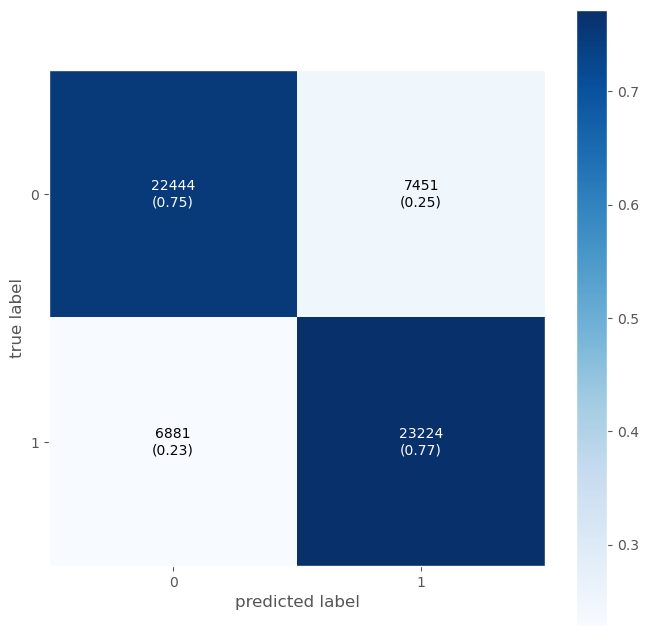

In [41]:
print('\n')
print("confusion matrix")
print('\n')
CR=confusion_matrix(Y_test, y_pred_)
print(CR)
print('\n')

fig, ax = plot_confusion_matrix(conf_mat=CR,figsize=(8, 8),
                                show_absolute=True,
                                show_normed=True,
                                colorbar=True)
plt.show()

### Receiver Operating Characteristic: ROC CURVE

- ROC curve show the performance of the model as well.
- We can see that the model started from the 0 percent predictions and then moved to true positive predictions that are correct 
- ROC curve (receiver operating characteristic curve) show the performance of a classification model at all the classification thresholds. ROC plots two parameters, True Positive Rate (correct predictions/classifications) False Positive Rate (wrong predictions/classifications)

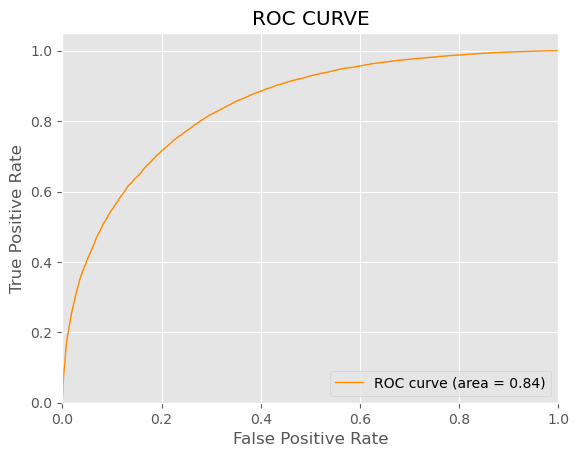

In [42]:
fpr, tpr, thresholds = roc_curve(Y_test, y_pred)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC CURVE')
plt.legend(loc="lower right")
plt.show()

# Improvements?

### Cross-Validation

In [44]:
# Convert Y_train to a numpy array
Y_train_ = Y_train.reset_index(drop=True)

# Set up k-fold cross-validation
kf = KFold(n_splits=3, shuffle=True, random_state=42)

# Initialize lists to store accuracy for each fold
training_accuracies = []
validation_accuracies = []

# Loop over each fold
for train_index, val_index in kf.split(X_train):
    # Split data for the current fold
    X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
    Y_train_fold, Y_val_fold = Y_train_[train_index], Y_train_[val_index]
    
    # Train the model on the current fold
    history = model.fit(X_train_fold, Y_train_fold, epochs=10, validation_data=(X_val_fold, Y_val_fold))
    
    # Store the training and validation accuracy for each epoch
    training_accuracies.append(history.history['accuracy'])
    validation_accuracies.append(history.history['val_accuracy'])

Epoch 1/10
2917/2917 ━━━━━━━━━━━━━━━━━━━━ 438s 150ms/step - accuracy: 0.7679 - loss: 0.4876 - val_accuracy: 0.7683 - val_loss: 0.4879
Epoch 2/10
2917/2917 ━━━━━━━━━━━━━━━━━━━━ 441s 150ms/step - accuracy: 0.7778 - loss: 0.4716 - val_accuracy: 0.7689 - val_loss: 0.4864
Epoch 3/10
2917/2917 ━━━━━━━━━━━━━━━━━━━━ 434s 147ms/step - accuracy: 0.7876 - loss: 0.4564 - val_accuracy: 0.7695 - val_loss: 0.4795
Epoch 4/10
2917/2917 ━━━━━━━━━━━━━━━━━━━━ 434s 149ms/step - accuracy: 0.7947 - loss: 0.4477 - val_accuracy: 0.7666 - val_loss: 0.4882
Epoch 5/10
2917/2917 ━━━━━━━━━━━━━━━━━━━━ 437s 147ms/step - accuracy: 0.7992 - loss: 0.4393 - val_accuracy: 0.7666 - val_loss: 0.4886
Epoch 6/10
2917/2917 ━━━━━━━━━━━━━━━━━━━━ 420s 140ms/step - accuracy: 0.8088 - loss: 0.4279 - val_accuracy: 0.7671 - val_loss: 0.4972
Epoch 7/10
2917/2917 ━━━━━━━━━━━━━━━━━━━━ 451s 143ms/step - accuracy: 0.8125 - loss: 0.4203 - val_accuracy: 0.7619 - val_loss: 0.5067
Epoch 8/10
2917/2917 ━━━━━━━━━━━━━━━━━━━━ 443s 143ms/step - ac

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



2917/2917 ━━━━━━━━━━━━━━━━━━━━ 412s 141ms/step - accuracy: 0.8502 - loss: 0.3557 - val_accuracy: 0.8273 - val_loss: 0.4169
Epoch 6/10
2029/2917 ━━━━━━━━━━━━━━━━━━━━ 1:48 122ms/step - accuracy: 0.8552 - loss: 0.3410

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



2917/2917 ━━━━━━━━━━━━━━━━━━━━ 452s 145ms/step - accuracy: 0.8542 - loss: 0.3433 - val_accuracy: 0.8177 - val_loss: 0.4552
Epoch 7/10
2917/2917 ━━━━━━━━━━━━━━━━━━━━ 406s 139ms/step - accuracy: 0.8639 - loss: 0.3220 - val_accuracy: 0.8125 - val_loss: 0.4725
Epoch 8/10
2917/2917 ━━━━━━━━━━━━━━━━━━━━ 409s 140ms/step - accuracy: 0.8705 - loss: 0.3067 - val_accuracy: 0.8071 - val_loss: 0.5130
Epoch 9/10
2917/2917 ━━━━━━━━━━━━━━━━━━━━ 403s 138ms/step - accuracy: 0.8756 - loss: 0.2936 - val_accuracy: 0.8030 - val_loss: 0.5444
Epoch 10/10
2917/2917 ━━━━━━━━━━━━━━━━━━━━ 446s 140ms/step - accuracy: 0.8824 - loss: 0.2806 - val_accuracy: 0.7984 - val_loss: 0.5769


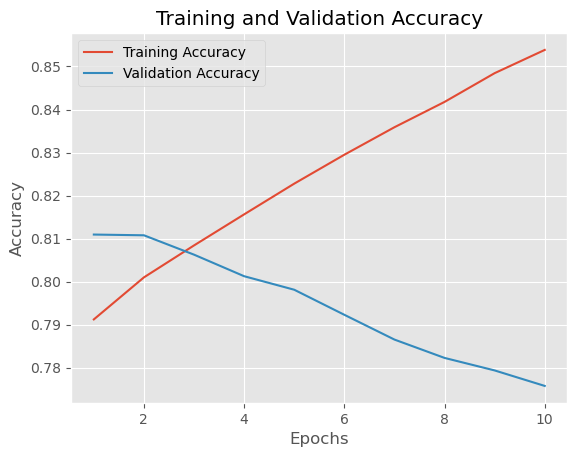

In [49]:
# Convert lists to numpy arrays for easier averaging
training_accuracies = np.array(training_accuracies)
validation_accuracies = np.array(validation_accuracies)

# Calculate mean accuracy across folds for each epoch
mean_training_accuracy = np.mean(training_accuracies, axis=0)
mean_validation_accuracy = np.mean(validation_accuracies, axis=0)

# Plot the training and validation accuracy
epochs = range(1, len(mean_training_accuracy) + 1)
plt.plot(epochs, mean_training_accuracy, label='Training Accuracy')
plt.plot(epochs, mean_validation_accuracy, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()


In [50]:
# we are starting to test the model here
accr1 = model.evaluate(X_test,Y_test)


print('Test set\n  Accuracy: {:0.2f}'.format(accr1[1])) #the accuracy of the model on test data is given below

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 77s 41ms/step - accuracy: 0.7322 - loss: 0.8357
Test set
  Accuracy: 0.73


In [51]:
y_pred = model.predict(X_test) #getting predictions on the trained model
y_pred_ = (y_pred > 0.5) 

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 70s 37ms/step




confusion matrix


[[22070  7825]
 [ 8182 21923]]




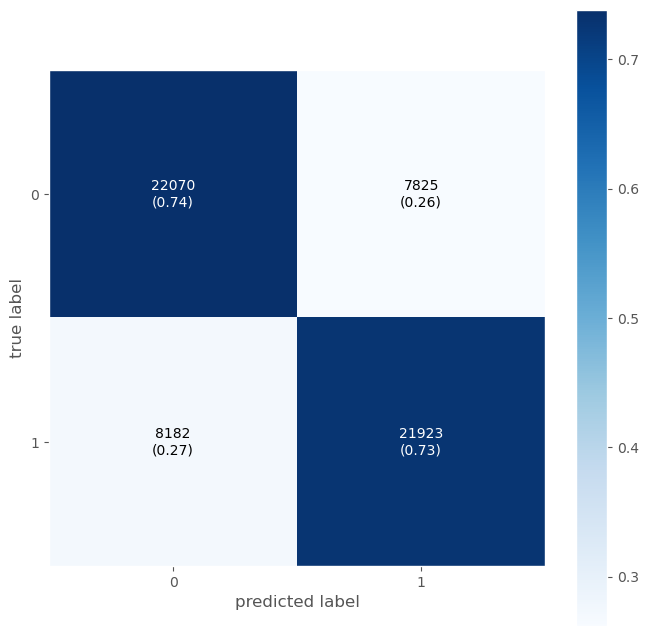

In [52]:
print('\n')
print("confusion matrix")
print('\n')
CR=confusion_matrix(Y_test, y_pred_)
print(CR)
print('\n')

fig, ax = plot_confusion_matrix(conf_mat=CR,figsize=(8, 8),
                                show_absolute=True,
                                show_normed=True,
                                colorbar=True)
plt.show()

If your model isn’t classifying properly, here are some potential improvements:

1. **Increase Model Complexity**: Add more layers or neurons.
2. **Hyperparameter Tuning**: Adjust learning rate, batch size, epochs.
3. **Try Different Architectures**: Experiment with CNNs, RNNs, or transformers if applicable.
4. **Feature Engineering**: Extract more relevant features or normalize/scale them.
5. **Data Augmentation**: Create synthetic samples to increase diversity.
6. **Use Regularization**: Add dropout layers or L2 regularization.
7. **Adjust Class Weights**: Handle class imbalance by setting `class_weight`.
8. **Collect More Data**: Gather more labeled examples if feasible.
9. **Ensemble Models**: Combine predictions from multiple models for robustness.

These approaches can improve your model's accuracy and generalization.